# Import the necessary libraries

In [287]:
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, square, rectangle, disk
from PIL import Image
from scipy import ndimage as ndi
from scipy.ndimage import convolve
from matplotlib import pyplot as plt

from skimage.filters import threshold_otsu
from skimage.filters import sato

# Segmentation algorithm

This method implements the following steps:

## Contrast Enhancement

During the pre-processing phase, we implement a method to rectify non-uniform illumination, a common issue observed in the original images characterized by varying intensities across different regions. This inconsistency can potentially disrupt subsequent segmentation stages. To address this, we employ the following formula:

$$G = \frac{I}{b} - b^{max} + 128$$

Where the corrected image G is derived by subtracting the maximum background illumination model (b) from the original image (I), divided by the same background illumination. This calculation is accompanied by an adjustment to ensure a mean value of approximately 128 for images with 256 gray levels.

This method significantly enhances image homogeneity and augments contrast, both crucial prerequisites for achieving a more precise final image. By mitigating illumination disparities, this procedure lays the groundwork for subsequent stages of image analysis, ensuring greater accuracy and reliability in the final output.

## Top-Hat Filter

The Top-Hat filter is a morphological image processing technique used for enhancing small bright structures or details within an image while suppressing the background. It is particularly useful for highlighting objects or features that are smaller than the structuring element used in the filtering process.

In our case, the Top-Hat is essential for this approach because we want to make the vessels more clear and distinguished from the background, even for the small ones. This filter is essentially a combination of an opening operation and the original image, where the first one involves applying an erosion operation followed by a dilation operation to the input image, that will help to remove noise and small features from the image while preserving larger structures.

After performing the opening operation, the original image is subtracted from the result, which produces an image that highlights the structures or details that were removed during the opening operation, that are typically small and bright compared to the background.

## Sato Tubeness Filter

The Sato filter, also known as the Frangi filter, is an image processing technique used for vessel enhancement and segmentation, particularly in medical imaging applications such as angiography and retinal imaging. The Sato filter operates by analyzing the local structure of an image to enhance tubular structures, such as blood vessels, while suppressing other image features like noise and background.

The Sato filter begins by computing the Hessian matrix at each pixel location in the input image. In the context of vessel enhancement, the Hessian matrix provides information about the curvature and orientation of structures in the image.

The Hessian matrix eigenvalues are analyzed, because they represent the principal curvatures of the local image structure, and, by examining it, the Sato filter identifies regions where the image intensity changes most significantly along certain directions, which often correspond to the presence of elongated structures like blood vessels, which is our goal to find.

This method can easily detect the vessels from our already filtered image by the Top Hat, making blood vessels more visible, that will be extremely necessarily for the next stages by reducing the appearance of unwanted structures.

## Threshold using Otsu's Method

A threshold is a value used to separate or classify pixels in an image into different groups or classes based on their intensity levels. When applying a threshold to an image, each pixel is compared to the threshold value, and depending on whether its intensity is above or below the threshold, it is assigned to one of the two classes: foreground or background.

So, in our approach, the filtered image is thresholded in order to obtain a binary representation of the vascular tree and, for that, we apply the Otsu's Method. This algorithm returns a single intensity threshold that separate pixels into two classes, foreground and background by finding an optimal threshold value that maximizes the between-class variance while minimizing the overlap between them.

## Post-processing

In the final stage, a series of morphological operations is deployed to refine the segmentation, reduce noise, and ensure connectivity among vessel segments that may have been fragmented in earlier steps. Our approach consists of a sequence beginning with an erosion operation to eliminate small, unwanted objects identified as noise. Subsequently, a dilation operation is applied to recover portions of vessels that may have been inadvertently removed during erosion. Finally, a closing operation is performed to facilitate the seamless connection of the restored vessel segments, reconstructing the complete vessel structures.

This strategy consists of a sequence of alternating morphological filters, where the combined action of dilation followed by erosion essentially constitutes an opening operation, subsequently complemented by a closing operation. Through this iterative process, noisy artifacts are suppressed, while small vessel components are reinstated and seamlessly integrated, ultimately culminating in the reconstruction of the details of the small vessels in the image.

## Evaluation method

<!-- 3. Expliquez la fonction d’´evaluation fournie dans le script Python. Pourquoi utilise-t-on deux
m´etriques (Pr´ecision et Rappel) ? Quel rˆole joue la squelettisation dans cette fonction d’´evaluation -->

The evaluation function uses two metrics to determine the quality of the segmentation algoritmhm. The first one, the precision, mesures how many pixels are correct among all those which were marked as true.

$$ \text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}} $$

The second metric is the recall, which measures the sensitivity of the algorithm. It indicates how many relevent pixels were able to be identified.

$$ \text{recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}} $$

These mectrics combined are able to assess the quality of the evaluation and also how specific it can be in identifying the relevant pixels.

In this method, the skeletonize function is used to facilitate the comparison between the reference image and the final obtained image, once this function is able to detect many important points that might appear in the results. 

The Skeletonization is a process of reducing foreground regions in a binary image to a skeletal remnant that largely preserves the extent and connectivity of the original region while throwing away most of the original foreground pixels. But, in the context of evaluating, the final image obtained from a segmentation process compared to reference images can show a simplified representation of the vessel networks for comparison, also we are able to observe if the topology of the vessel networks is accurately captured by the segmentation algorithm.

Most importantly, skeletonization offers a clear visual representation of vessel networks in both the segmented and reference images. This visual comparison allows us to easily assess how well the vessels line up and are distributed between the two images.

Accuracy = 90.33%, Recall = 75.81%.
F-score = 82.43%


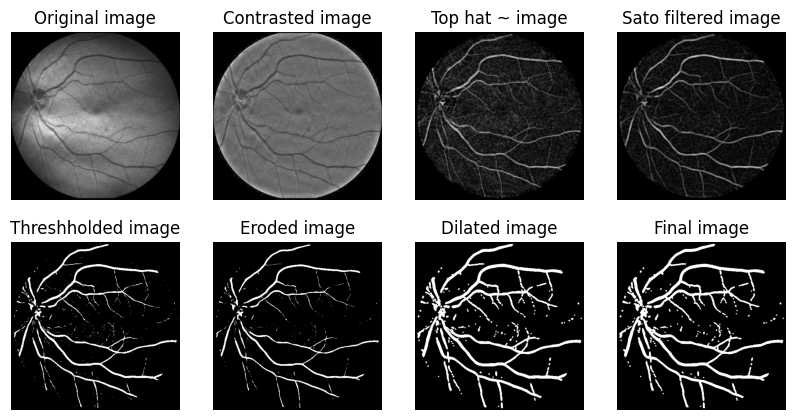

In [288]:
def my_segmentation(img, img_mask, closing_value = 2, dilation_value = 2, erosion_value=2, kernel_size = 41, tophat = 11, if_print=False, dilation_shape="disk", closing_shape="square", erosion_shape="vert_rect"):
    
    # -------------------------------
    # ORIGINAL IMAGE
    if(if_print):
        plt.figure(figsize=(10, 5))
        plt.subplot(2, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original image')
        plt.axis('off')
    # -------------------------------

    # -------------------------------
    # INCREASE IMAGE CONTRAST
    contrasted_img = img

    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size) # kernel for filtering
    backgound_mode = convolve(img, kernel) # low pass filter
    contrasted_img = np.divide(img, backgound_mode + 1) - backgound_mode.max() + 128 # apply transformation
    contrasted_img = 255 - np.absolute(contrasted_img) / np.max(np.absolute(contrasted_img)) * 255 # convert image into uint8

    if(if_print):
        plt.subplot(2, 4, 2)
        plt.imshow(contrasted_img, cmap='gray')
        plt.title('Contrasted image')
        plt.axis('off')
    # -------------------------------  
    
    # -------------------------------
    # TOPHAT FILTER
    tophat_ = contrasted_img

    tophat_ = ndi.grey_closing(contrasted_img, size=(tophat,tophat)) - contrasted_img # apply filter
    tophat_ = np.multiply(tophat_, img_mask.astype(np.uint8)) # ensure the image fits the mask

    if(if_print):
        plt.subplot(2, 4, 3)
        plt.imshow(tophat_, cmap='gray')
        plt.title('Top hat ~ image')
        plt.axis('off')
    # -------------------------------

    # -------------------------------
    # SATO IMAGE FILTER
    img_filtered = tophat_

    img_filtered = sato(img_filtered, black_ridges=False, sigmas = [1,2,3,4])
    img_filtered = np.multiply(img_filtered, img_mask.astype(np.uint8))

    if(if_print):
        plt.subplot(2, 4, 4)
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Sato filtered image')
        plt.axis('off')
    # -------------------------------

    # -------------------------------
    # THRESHOLD IMAGE
    threshhold_image = img_filtered

    thresh = threshold_otsu(img_filtered)
    threshhold_image = img_filtered > thresh

    if(if_print):
        plt.subplot(2, 4, 5)
        plt.imshow(threshhold_image, cmap='gray')
        plt.title('Threshholded image')
        plt.axis('off')
    # -------------------------------

    # -------------------------------
    # REMOVE SMALL OBJECTS WITH EROSION
    if(erosion_shape == "vert_rect"):
        threshhold_image = binary_erosion(threshhold_image, rectangle(erosion_value, 1))
    elif(erosion_shape == "hor_rect"):
        threshhold_image = binary_erosion(threshhold_image, rectangle(1, erosion_value))
    elif(erosion_shape == "square"):
        threshhold_image = binary_erosion(threshhold_image, square(erosion_value))
    elif(erosion_shape == "disk"):
        threshhold_image = binary_erosion(threshhold_image, disk(erosion_value))

    if(if_print):
        plt.subplot(2, 4, 6)
        plt.imshow(threshhold_image, cmap='gray')
        plt.title('Eroded image')
        plt.axis('off')
    # -------------------------------

    # -------------------------------
    # INCREASE OBJECT SIZES WITH DILATION
    binary = threshhold_image

    if(dilation_shape == "vert_rect"):
        binary = binary_dilation(binary, rectangle(dilation_value, 1))
    elif(dilation_shape == "hor_rect"):
        binary = binary_dilation(binary, rectangle(1, dilation_value))
    elif(dilation_shape == "square"):
        binary = binary_dilation(binary, square(dilation_value))
    elif(dilation_shape == "disk"):
        binary = binary_dilation(binary, disk(dilation_value))
    if(if_print):
        plt.subplot(2, 4, 7)
        plt.imshow(binary, cmap='gray')
        plt.title('Dilated image')
        plt.axis('off')
    # -------------------------------

    # -------------------------------
    # CONNECT THE REMAINING OBJECTS WITH CLOSING
    if(closing_shape == "vert_rect"):
        binary = binary_closing(binary, rectangle(closing_value, 1))
    elif(closing_shape == "hor_rect"):
        binary = binary_closing(binary, rectangle(1, closing_value))
    elif(closing_shape == "square"):
        binary = binary_closing(binary, square(closing_value))
    elif(closing_shape == "disk"):
        binary = binary_closing(binary, disk(closing_value))
    if(if_print):
        plt.subplot(2, 4, 8)
        plt.imshow(binary, cmap='gray')
        plt.title('Final image')
        plt.axis('off')
    # -------------------------------
    
    return binary

def evaluate(img_out, img_GT):
    GT_skel = skeletonize(img_GT) # we reduce the evaluation's support
    img_out_skel = skeletonize(img_out) # to the skeleton's pixels
    TP = np.sum(img_out_skel & img_GT) # true positives
    FP = np.sum(img_out_skel & ~img_GT) # false positives
    FN = np.sum(GT_skel & ~img_out) # false negatives

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel

img_code = '01'

# open original image in grayscale, read as an ndarray with values between 0 and 256
img =  np.asarray(Image.open('./images_IOSTAR/star' + img_code + '_OSC.jpg')).astype(np.uint8)

# create image mask, which delimits the eye in the figure
nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]
# we consider only the pixels inside the circle
img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > ((0.975 * nrows / 2)**2))
img_mask[invalid_pixels] = 0

# we also take into account the empty rows of pixels in the top and bottom of the image
nb_lines = 6
for i in range(ncols):
    for j in range(nb_lines):
        img_mask[j][i] = 0
        img_mask[nrows - j - 1][i] = 0

# this segmentation is done with the parameters which maximized the average between the accuracy and the recall
# this represents the best results that were able to be obtained
img_out = my_segmentation(img, img_mask, if_print=True)
img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_' + img_code + '.png')).astype(np.bool_)

ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
print('Accuracy = ', round(100 * ACCU, 2),'%', ', Recall = ', round(100*RECALL, 2), '%.', sep="")
print("F-score = ", round(100 * 2 * ACCU * RECALL / (ACCU + RECALL), 2), "%", sep="")

# Parameters finetuning 

## Contrast

The parameter investigated here is the kernel size for the convolution which models the background of the image, as discussed previously. It was varied between 11 and 81, and the value which renders the highest average between the accuracy and the recall was 41, though the results were not very sensitive to this parameter.

K =  11 , Accuracy = 0.8671772428884026 , Recall = 0.7844418052256532
K =  21 , Accuracy = 0.9151683970625475 , Recall = 0.7327656123276561
K =  31 , Accuracy = 0.9020457280385078 , Recall = 0.7551883941164618
K =  41 , Accuracy = 0.9033341328855841 , Recall = 0.7580515297906603
K =  51 , Accuracy = 0.8987161198288159 , Recall = 0.7584269662921348
K =  61 , Accuracy = 0.8973752660203358 , Recall = 0.7623543591803937
K =  71 , Accuracy = 0.8986405914619604 , Recall = 0.7563227619429947
K =  81 , Accuracy = 0.8925422921134143 , Recall = 0.7579927154997976


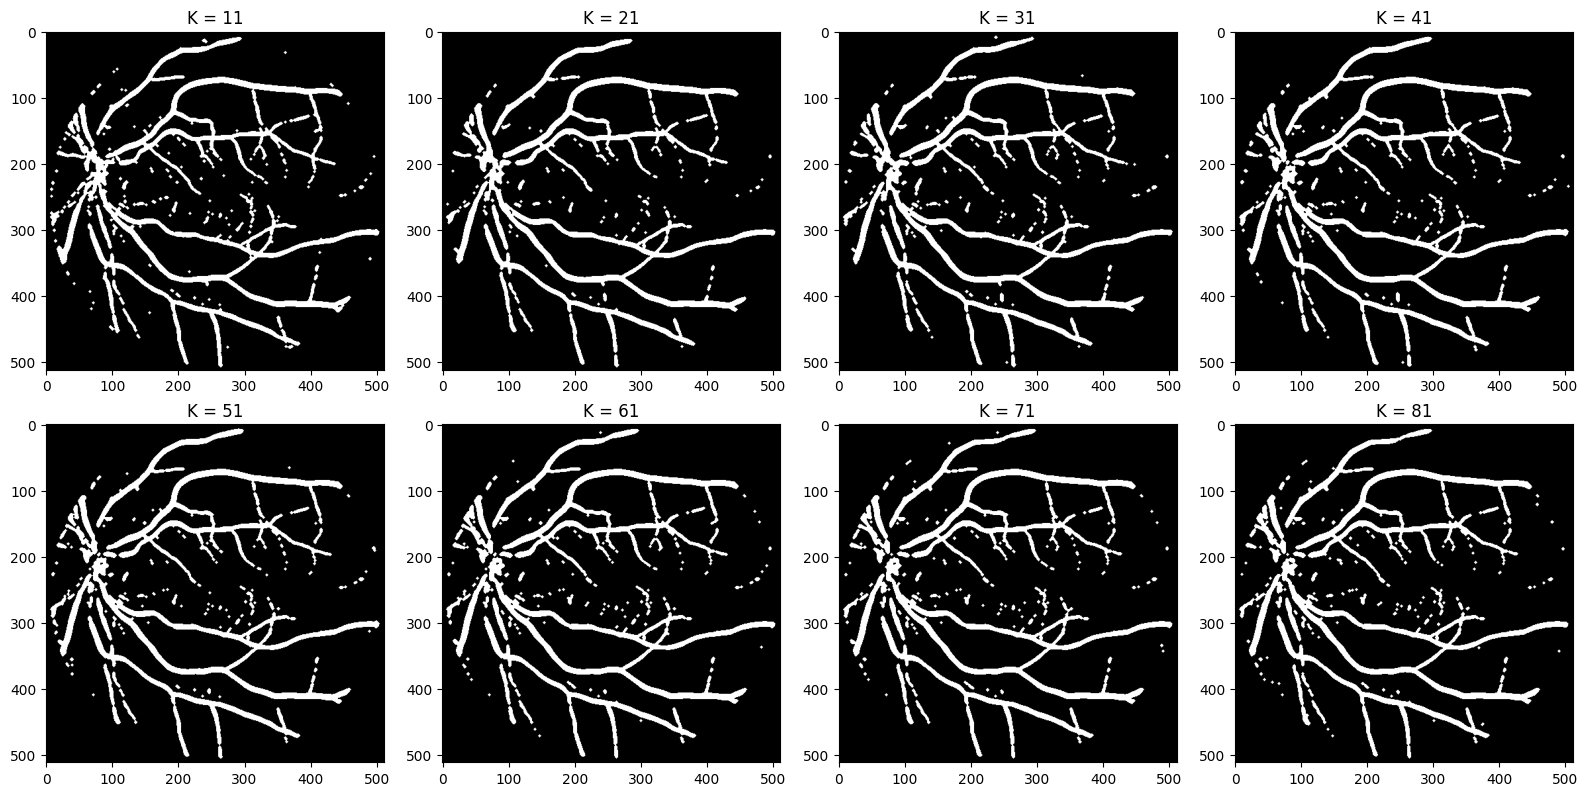

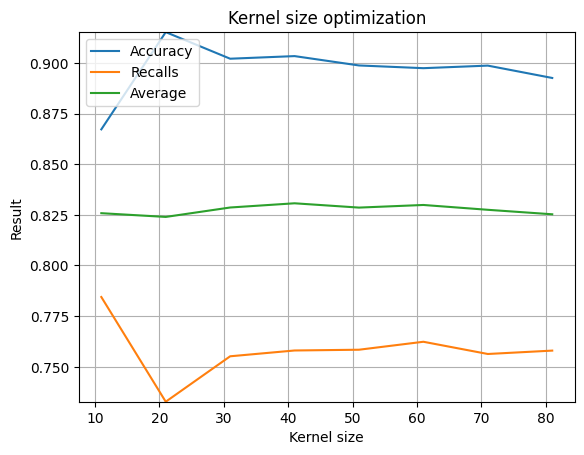

In [289]:
plt.figure(figsize=(16, 8))

test_kernel_sizes = [11, 21, 31, 41, 51, 61, 71, 81]
accuracies = np.zeros((len(test_kernel_sizes),1))
recalls = np.zeros((len(test_kernel_sizes),1))

i = 1
for kernel_size in test_kernel_sizes:
    img_out = my_segmentation(img, img_mask, kernel_size=kernel_size)
    img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

    ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
    print('K = ', kernel_size, ', Accuracy =', ACCU,', Recall =', RECALL)
    accuracies[i - 1] = ACCU
    recalls[i - 1] = RECALL

    plt.subplot(2, 4, i)
    plt.imshow(img_out,cmap = 'gray')
    plt.title('K = ' + str(kernel_size))
    i = i + 1

plt.tight_layout()
plt.show()

plt.plot(test_kernel_sizes, accuracies, label='Accuracy')
plt.plot(test_kernel_sizes, recalls, label='Recalls')
plt.plot(test_kernel_sizes, (accuracies + recalls) / 2, label='Average')

plt.ylim(min([np.min(accuracies), np.min(recalls)]), max([np.max(accuracies), np.max(recalls)]))

plt.xlabel('Kernel size')
plt.ylabel('Result')
plt.title('Kernel size optimization')

plt.legend()

plt.grid(True)
plt.show()

## Tophat

The parameter investigated in this case is the kernel size for the closing used by the complementary tophat filter. It was varied between 7 and 21, and the value which renders the highest average between the accuracy and the recall was 11.

K =  7 , Accuracy = 0.8526072329688814 , Recall = 0.8063233247166435
K =  9 , Accuracy = 0.8916959064327485 , Recall = 0.7648475120385233
K =  11 , Accuracy = 0.9033341328855841 , Recall = 0.7580515297906603
K =  13 , Accuracy = 0.9021686746987951 , Recall = 0.7540785498489426
K =  15 , Accuracy = 0.8851102941176471 , Recall = 0.7691693290734825
K =  17 , Accuracy = 0.8801576263328698 , Recall = 0.7666060973147587
K =  19 , Accuracy = 0.8708715596330275 , Recall = 0.7667609046849758
K =  21 , Accuracy = 0.8688790902761662 , Recall = 0.7577413479052824


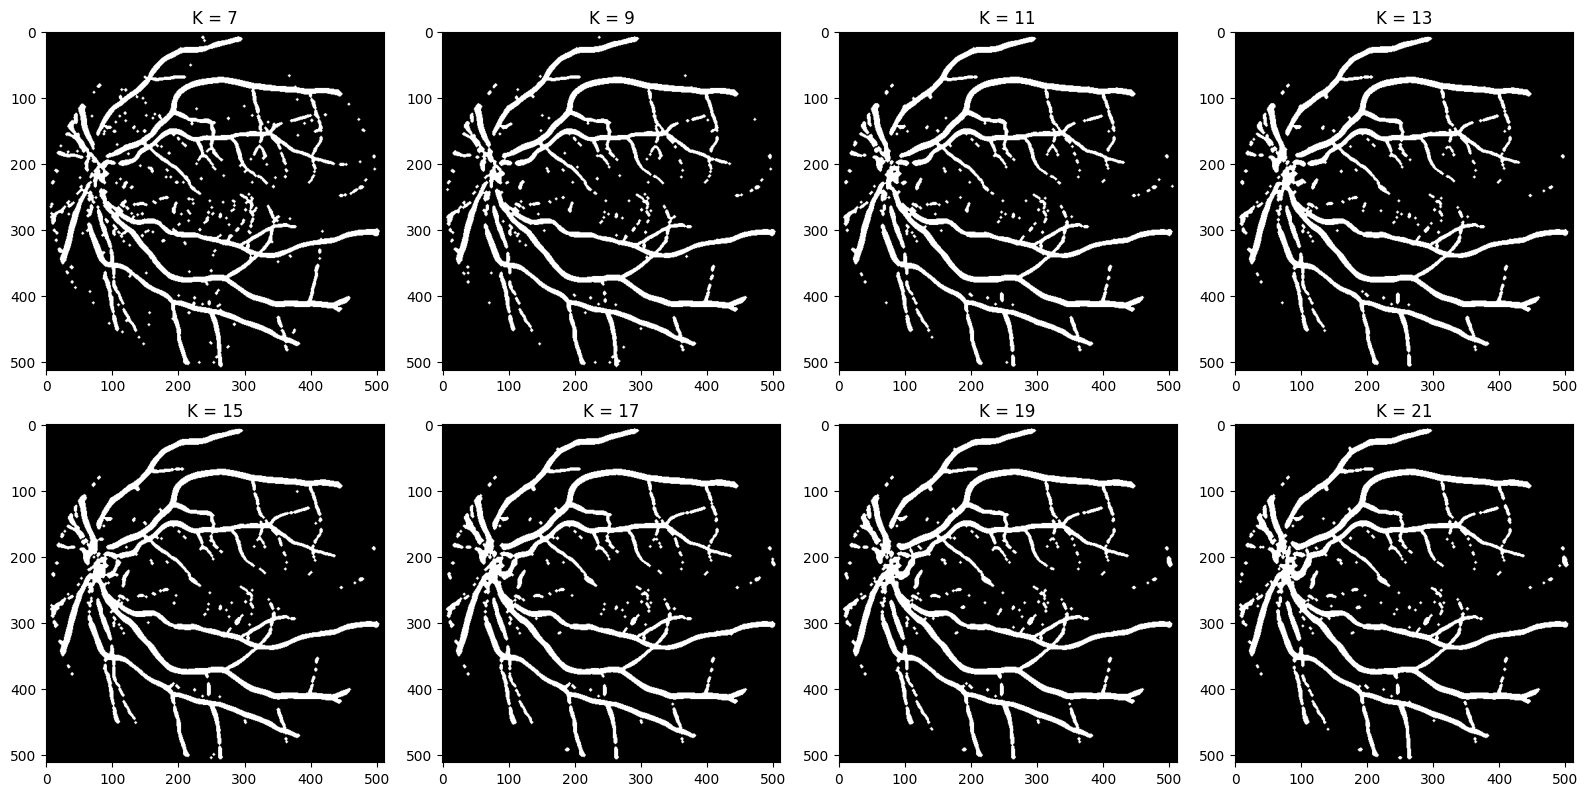

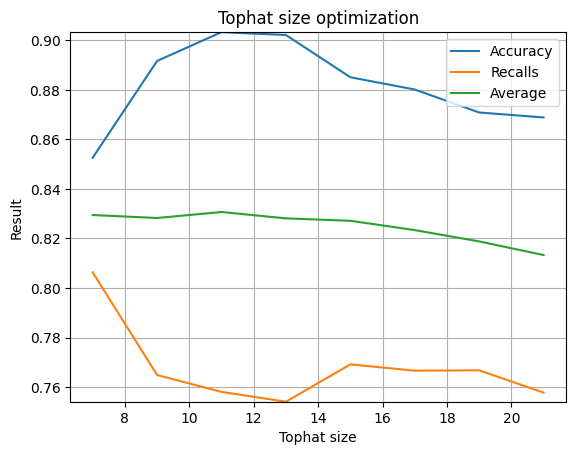

In [290]:
plt.figure(figsize=(16, 8))

test_tophat_sizes = [7, 9, 11, 13, 15, 17, 19, 21]
accuracies = np.zeros((len(test_tophat_sizes),1))
recalls = np.zeros((len(test_tophat_sizes),1))

i = 1
for tophat_size in test_tophat_sizes:
    img_out = my_segmentation(img, img_mask, tophat=tophat_size)
    img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

    ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
    print('K = ', tophat_size, ', Accuracy =', ACCU,', Recall =', RECALL)
    accuracies[i - 1] = ACCU
    recalls[i - 1] = RECALL

    plt.subplot(2, 4, i)
    plt.imshow(img_out,cmap = 'gray')
    plt.title('K = ' + str(tophat_size))
    i = i + 1

plt.tight_layout()
plt.show()

plt.plot(test_tophat_sizes, accuracies, label='Accuracy')
plt.plot(test_tophat_sizes, recalls, label='Recalls')
plt.plot(test_tophat_sizes, (accuracies + recalls) / 2, label='Average')

plt.ylim(min([np.min(accuracies), np.min(recalls)]), max([np.max(accuracies), np.max(recalls)]))

plt.xlabel('Tophat size')
plt.ylabel('Result')
plt.title('Tophat size optimization')

plt.legend()

plt.grid(True)
plt.show()

## Erosion

For the binary transformations, two parameters were investigated: the kernel size and the kernel shape. The chosen shapes were a vertical rectangle, a horizontal rectangle, a square and a disk. In this case, the best result found used a vertical rectangle of size 2.

K =  1 , Shape = vert_rect , Accuracy = 0.8039976712594605 , Recall = 0.8284343131373725 , Average =  0.8162159921984165
K =  2 , Shape = vert_rect , Accuracy = 0.9033341328855841 , Recall = 0.7580515297906603 , Average =  0.8306928313381221
K =  3 , Shape = vert_rect , Accuracy = 0.931766704416761 , Recall = 0.6653861706429438 , Average =  0.7985764375298524
K =  1 , Shape = hor_rect , Accuracy = 0.8039976712594605 , Recall = 0.8284343131373725 , Average =  0.8162159921984165
K =  2 , Shape = hor_rect , Accuracy = 0.8933400100150225 , Recall = 0.7299509001636661 , Average =  0.8116454550893444
K =  3 , Shape = hor_rect , Accuracy = 0.9316370324954016 , Recall = 0.6171811535337124 , Average =  0.7744090930145571
K =  1 , Shape = square , Accuracy = 0.8039976712594605 , Recall = 0.8284343131373725 , Average =  0.8162159921984165
K =  2 , Shape = square , Accuracy = 0.941348117887365 , Recall = 0.6506655909640984 , Average =  0.7960068544257317
K =  3 , Shape = square , Accuracy = 0.9542

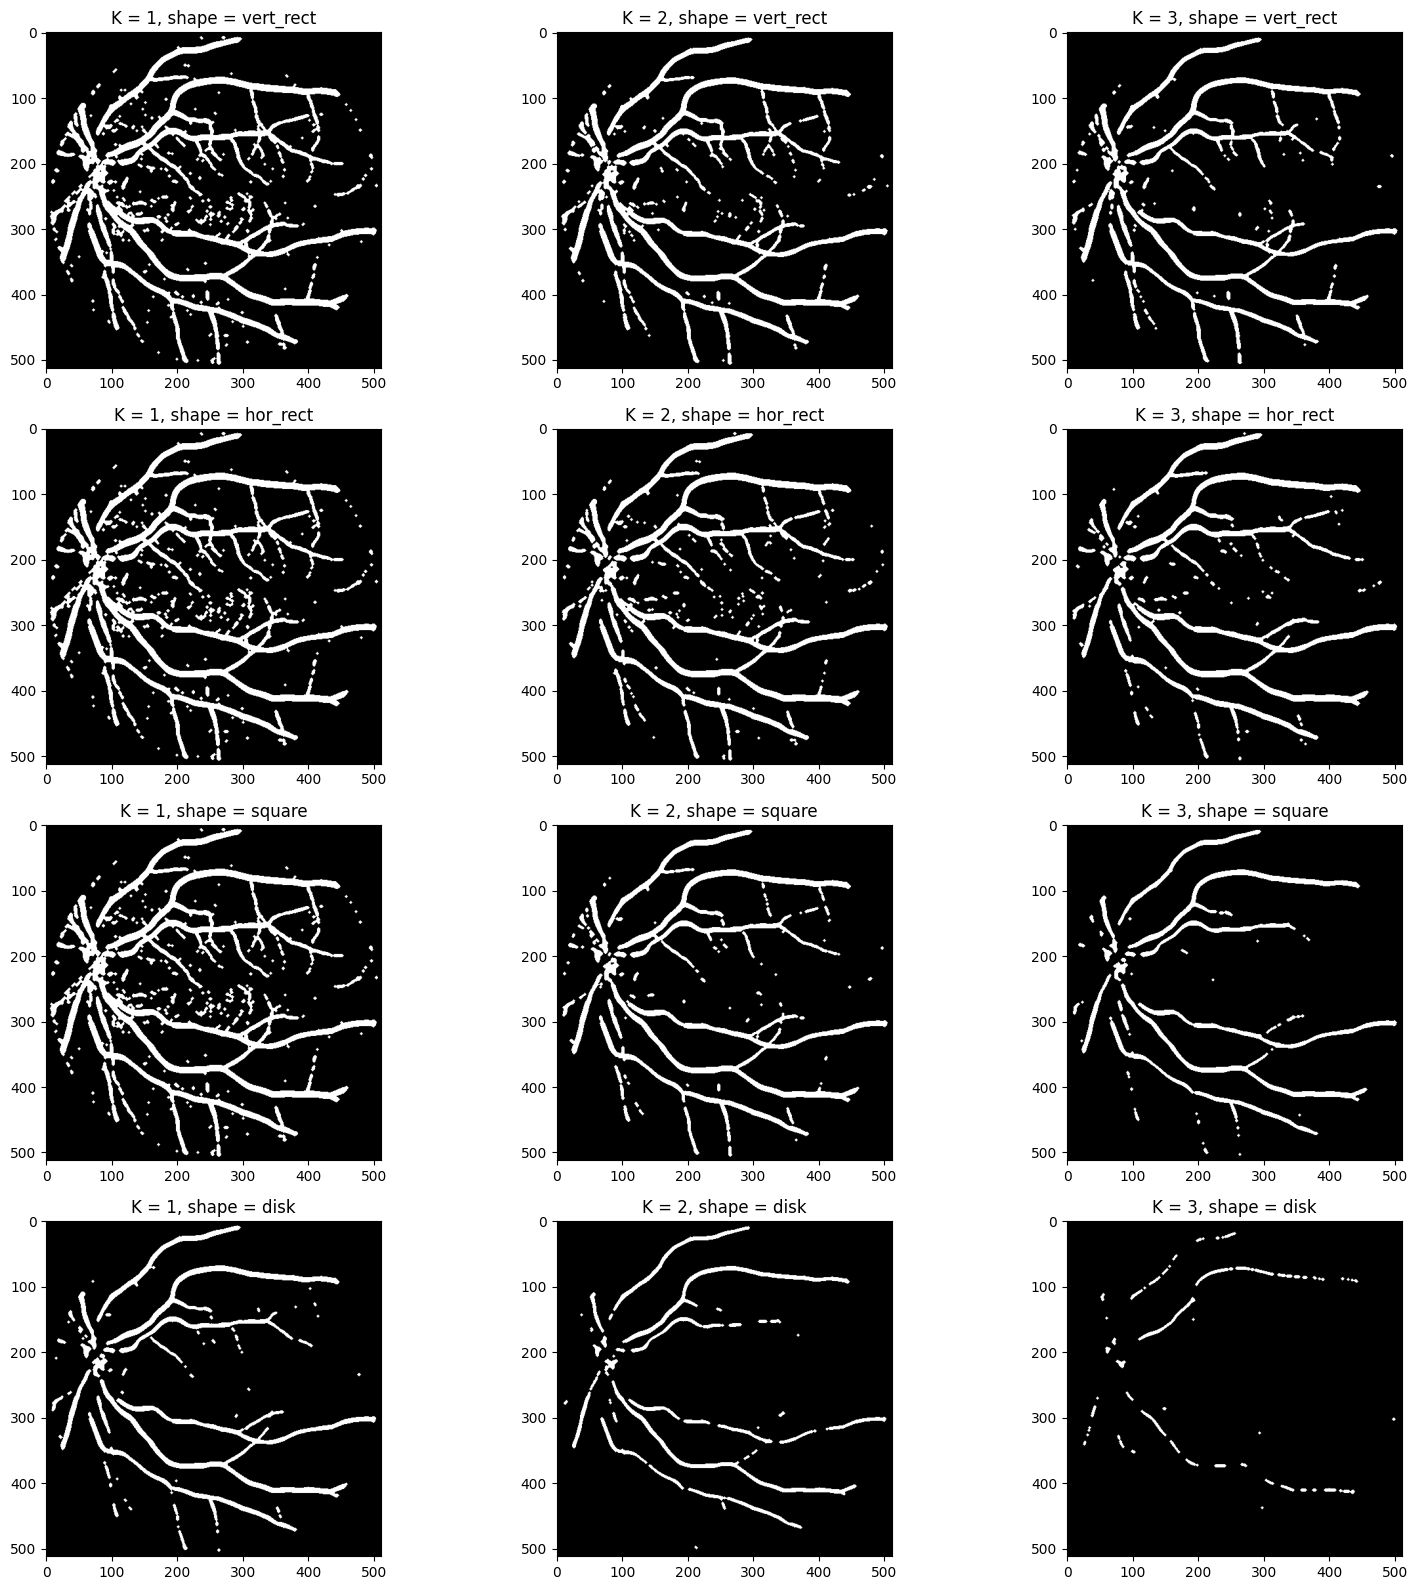

In [291]:
plt.figure(figsize=(16, 16))

test_erosion_sizes = [1,2,3]
test_erosion_shapes = ["vert_rect", "hor_rect", "square", "disk"]
accuracies = np.zeros((len(test_erosion_shapes),len(test_erosion_sizes)))
recalls = np.zeros((len(test_erosion_shapes),len(test_erosion_sizes)))

i = 0
for erosion_shape in test_erosion_shapes:
    j = 0
    for erosion_size in test_erosion_sizes:
        img_out = my_segmentation(img, img_mask, erosion_value=erosion_size, erosion_shape=erosion_shape)
        img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

        ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
        print('K = ', erosion_size, ', Shape =', erosion_shape, ', Accuracy =', ACCU,', Recall =', RECALL, ', Average = ', (ACCU + RECALL) / 2)
        accuracies[i][j] = ACCU
        recalls[i][j] = RECALL

        plt.subplot(len(test_erosion_shapes), len(test_erosion_sizes), i * len(test_erosion_sizes) + j + 1)
        plt.imshow(img_out,cmap = 'gray')
        plt.title('K = ' + str(erosion_size) + ', shape = ' + erosion_shape)
        j = j + 1
    i = i + 1

plt.tight_layout()
plt.show()

## Dilation

The investigation process was done similarly to the erosion. Here, the best result was found to be a disk of size 2.

K =  1 , Shape = vert_rect , Accuracy = 0.9069942341438957 , Recall = 0.6285615010423905 , Average =  0.767777867593143
K =  2 , Shape = vert_rect , Accuracy = 0.8986583612841399 , Recall = 0.6746402877697841 , Average =  0.786649324526962
K =  3 , Shape = vert_rect , Accuracy = 0.8801472279733149 , Recall = 0.6934928403117636 , Average =  0.7868200341425393
K =  1 , Shape = hor_rect , Accuracy = 0.9069942341438957 , Recall = 0.6285615010423905 , Average =  0.767777867593143
K =  2 , Shape = hor_rect , Accuracy = 0.8757020757020757 , Recall = 0.6407003752010005 , Average =  0.7582012254515381
K =  3 , Shape = hor_rect , Accuracy = 0.8784608165180666 , Recall = 0.6897568165070007 , Average =  0.7841088165125336
K =  1 , Shape = square , Accuracy = 0.9069942341438957 , Recall = 0.6285615010423905 , Average =  0.767777867593143
K =  2 , Shape = square , Accuracy = 0.8816011574632264 , Recall = 0.6847724292938753 , Average =  0.7831867933785508
K =  3 , Shape = square , Accuracy = 0.890286

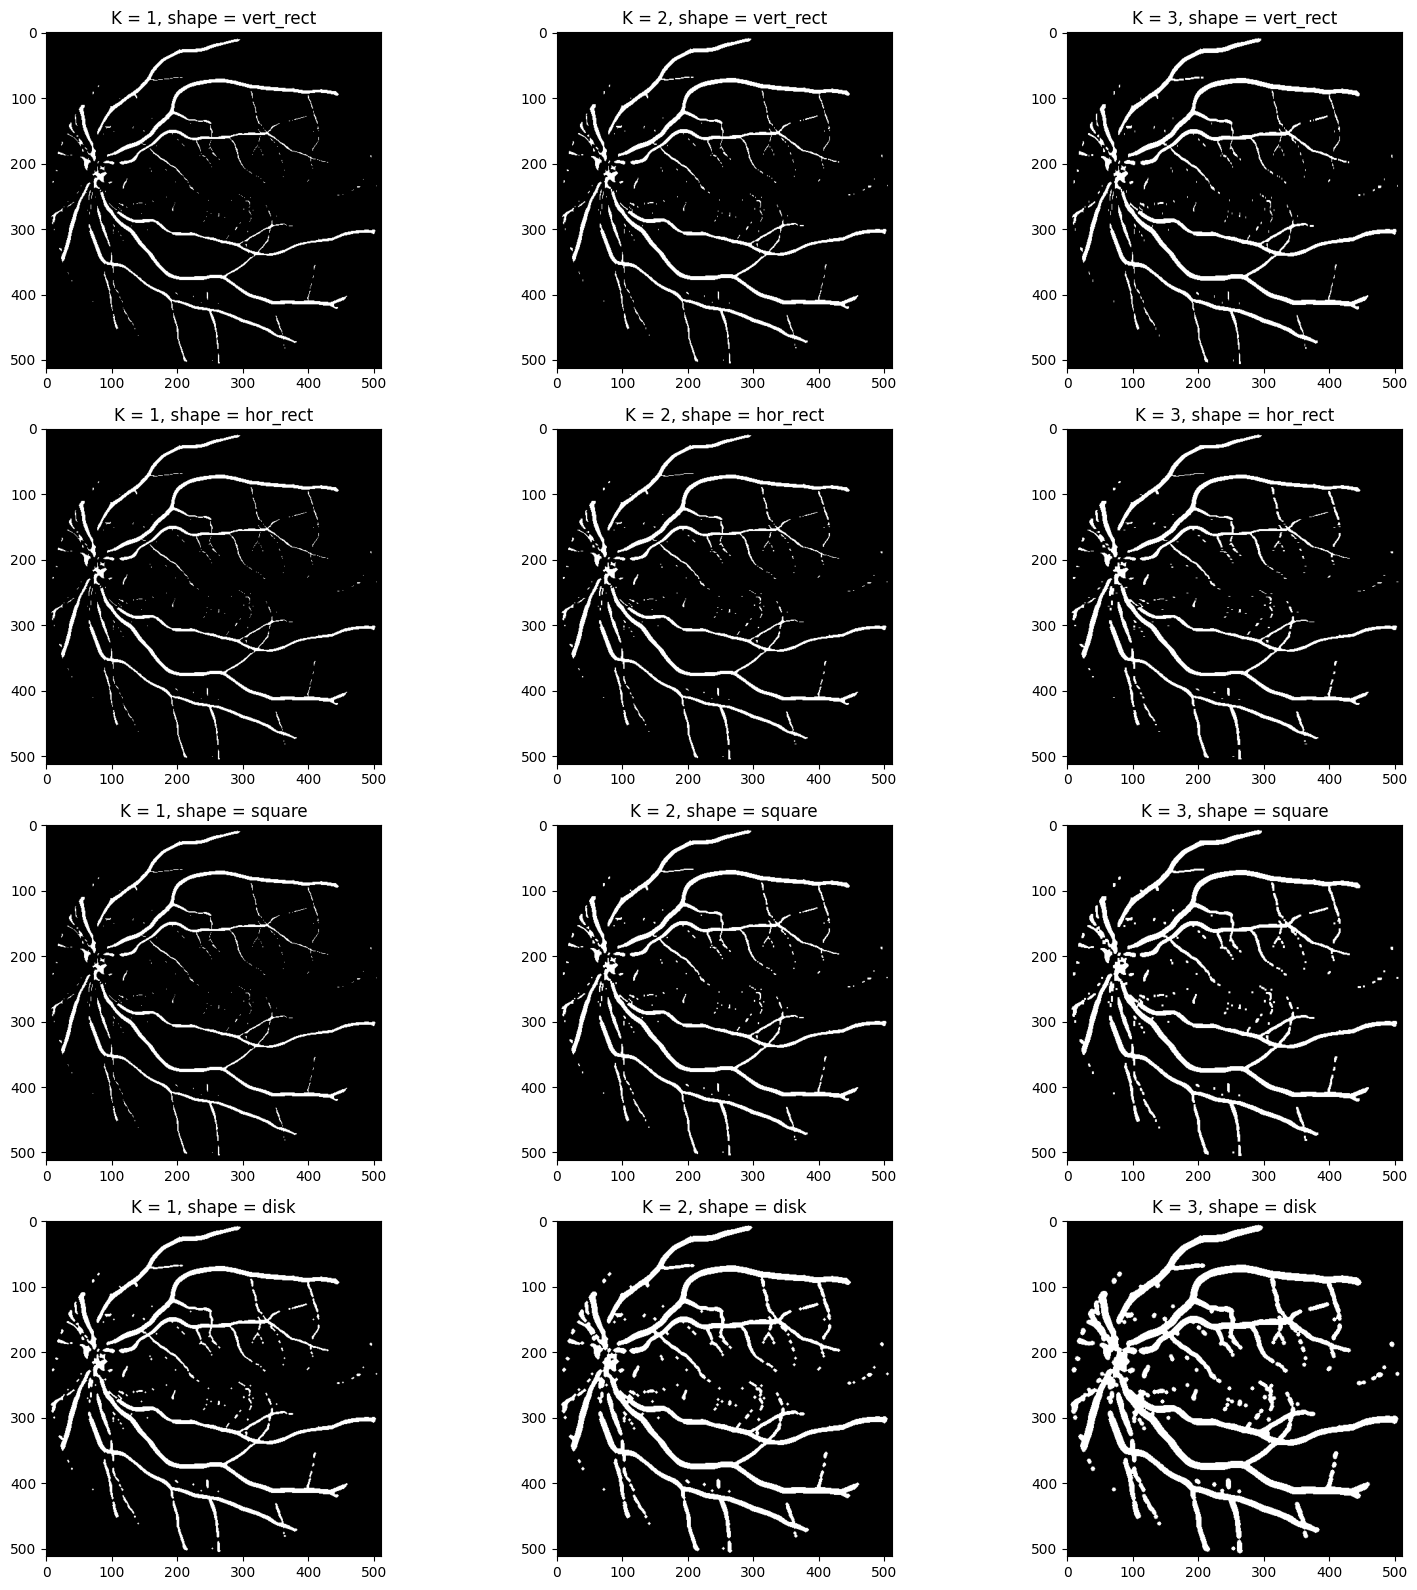

In [292]:
plt.figure(figsize=(16, 16))

test_dilation_sizes = [1,2,3]
test_dilation_shapes = ["vert_rect", "hor_rect", "square", "disk"]
accuracies = np.zeros((len(test_dilation_shapes),len(test_dilation_sizes)))
recalls = np.zeros((len(test_dilation_shapes),len(test_dilation_sizes)))

i = 0
for dilation_shape in test_dilation_shapes:
    j = 0
    for dilation_size in test_dilation_sizes:
        img_out = my_segmentation(img, img_mask, dilation_shape=dilation_shape, dilation_value=dilation_size)
        img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

        ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
        print('K = ', dilation_size, ', Shape =', dilation_shape, ', Accuracy =', ACCU,', Recall =', RECALL, ', Average = ', (ACCU + RECALL) / 2)
        accuracies[i][j] = ACCU
        recalls[i][j] = RECALL

        plt.subplot(len(test_dilation_shapes), len(test_dilation_sizes), i * len(test_dilation_sizes) + j + 1)
        plt.imshow(img_out,cmap = 'gray')
        plt.title('K = ' + str(dilation_size) + ', shape = ' + dilation_shape)
        j = j + 1
    i = i + 1

plt.tight_layout()
plt.show()

## Closing

Finally, for the closing transformation the best result used a 

K =  1 , Shape = vert_rect , Accuracy = 0.9043394869335891 , Recall = 0.754249150169966 , Average =  0.8292943185517776
K =  2 , Shape = vert_rect , Accuracy = 0.905870936438622 , Recall = 0.7541910725106039 , Average =  0.830031004474613
K =  3 , Shape = vert_rect , Accuracy = 0.8946492271105826 , Recall = 0.7589267702239257 , Average =  0.8267879986672542
K =  1 , Shape = hor_rect , Accuracy = 0.9043394869335891 , Recall = 0.754249150169966 , Average =  0.8292943185517776
K =  2 , Shape = hor_rect , Accuracy = 0.9092673459485686 , Recall = 0.7544283413848631 , Average =  0.8318478436667158
K =  3 , Shape = hor_rect , Accuracy = 0.9057918769526556 , Recall = 0.7580450522928399 , Average =  0.8319184646227478
K =  1 , Shape = square , Accuracy = 0.9043394869335891 , Recall = 0.754249150169966 , Average =  0.8292943185517776
K =  2 , Shape = square , Accuracy = 0.9033341328855841 , Recall = 0.7580515297906603 , Average =  0.8306928313381221
K =  3 , Shape = square , Accuracy = 0.8943378

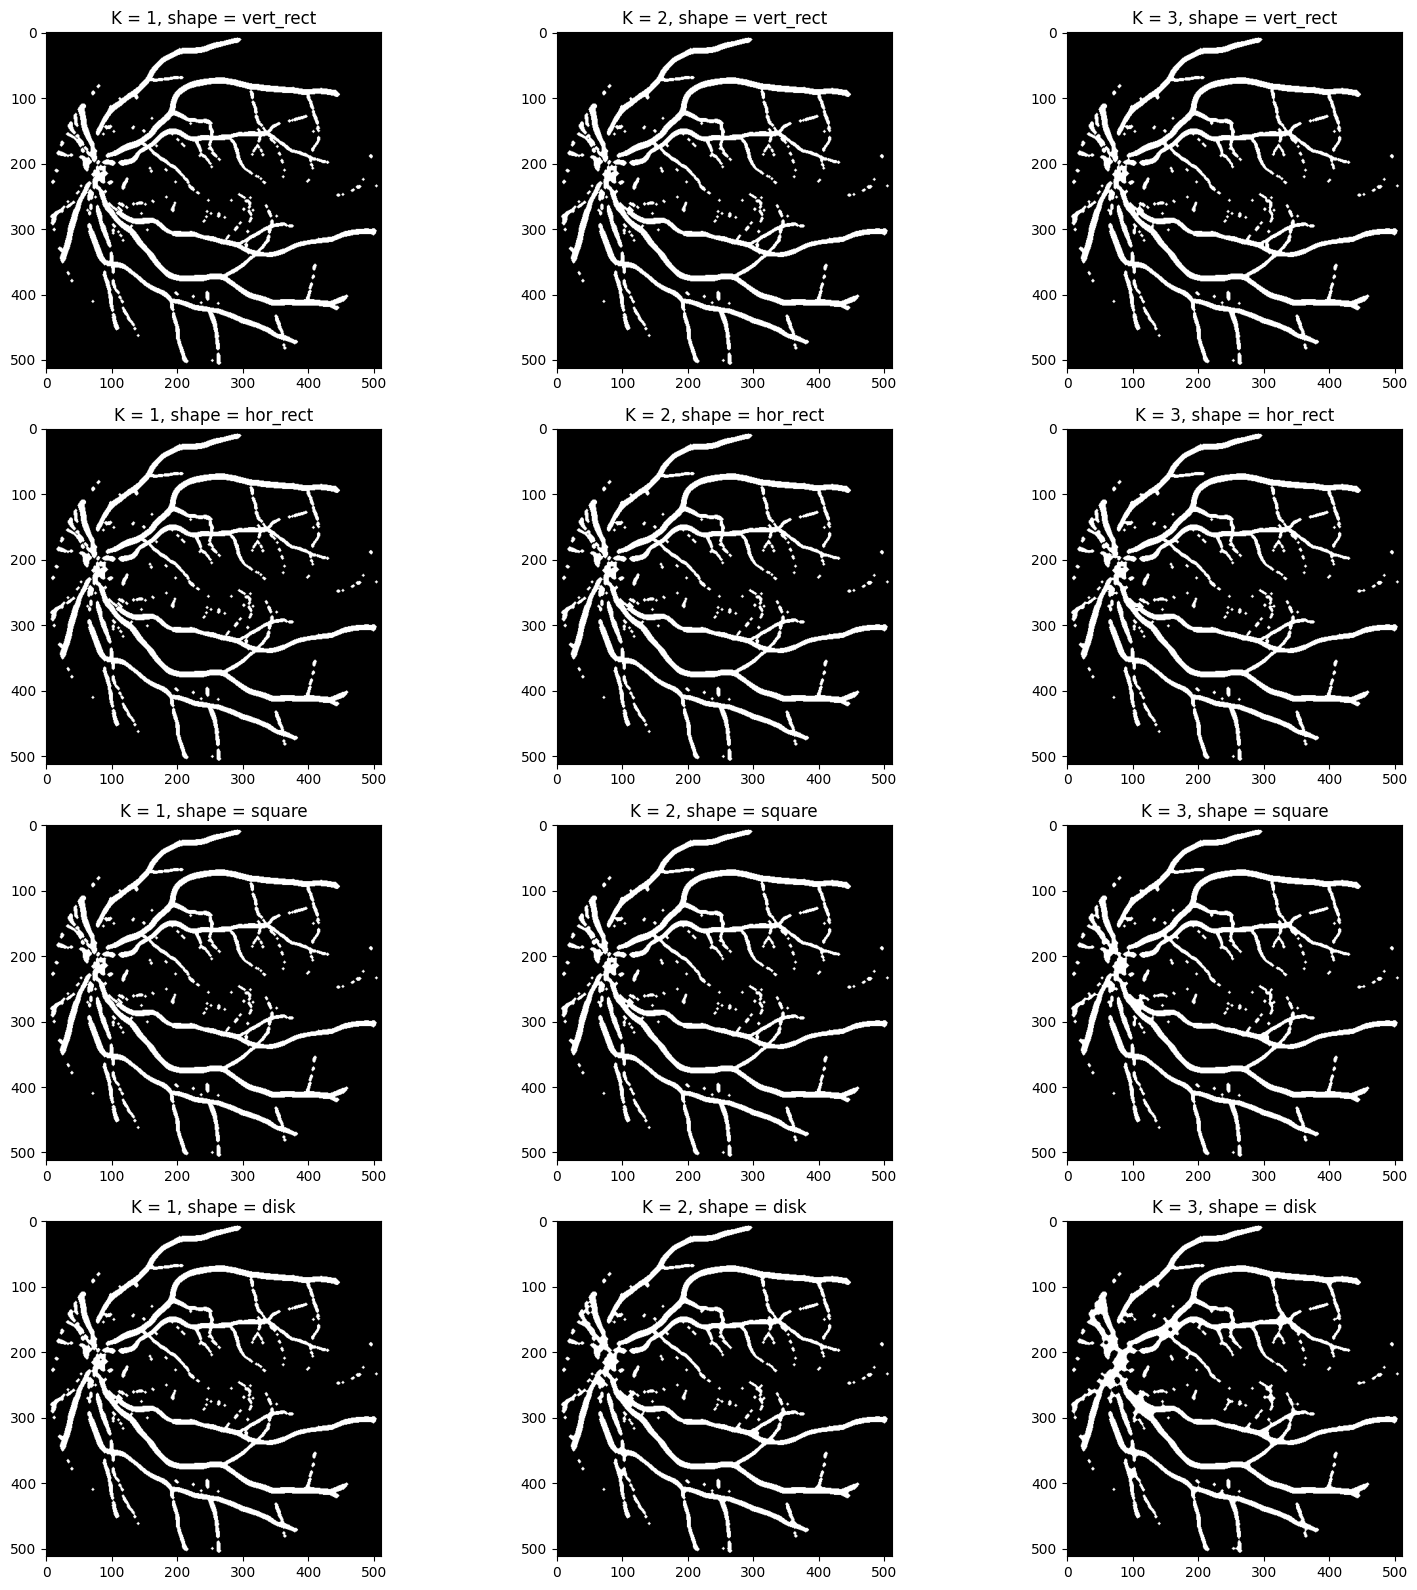

In [293]:
plt.figure(figsize=(16, 16))

test_closing_sizes = [1,2,3]
test_closing_shapes = ["vert_rect", "hor_rect", "square", "disk"]
accuracies = np.zeros((len(test_closing_shapes),len(test_closing_sizes)))
recalls = np.zeros((len(test_closing_shapes),len(test_closing_sizes)))

i = 0
for closing_shape in test_closing_shapes:
    j = 0
    for closing_size in test_closing_sizes:
        img_out = my_segmentation(img, img_mask, closing_shape=closing_shape, closing_value=closing_size)
        img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

        ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
        print('K = ', closing_size, ', Shape =', closing_shape, ', Accuracy =', ACCU,', Recall =', RECALL, ', Average = ', (ACCU + RECALL) / 2)
        accuracies[i][j] = ACCU
        recalls[i][j] = RECALL

        plt.subplot(len(test_closing_shapes), len(test_closing_sizes), i * len(test_closing_sizes) + j + 1)
        plt.imshow(img_out,cmap = 'gray')
        plt.title('K = ' + str(closing_size) + ', shape = ' + closing_shape)
        j = j + 1
    i = i + 1

plt.tight_layout()
plt.show()

## Comparison with the expected result

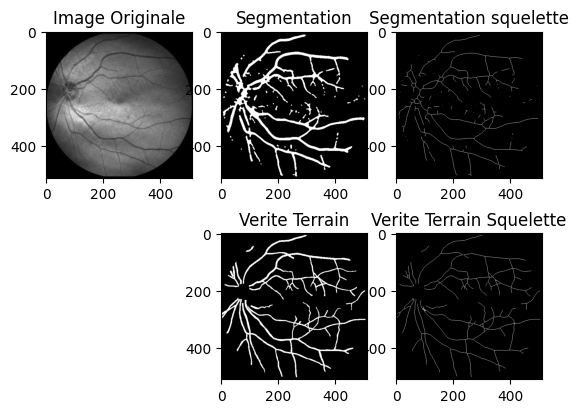

In [294]:
plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
plt.subplot(232)
plt.imshow(img_out, cmap='grey')
plt.title('Segmentation')
plt.subplot(233)
plt.imshow(img_out_skel, cmap='gray')
plt.title('Segmentation squelette')
plt.subplot(235)
plt.imshow(img_GT, cmap='gray')
plt.title('Verite Terrain')
plt.subplot(236)
plt.imshow(GT_skel, cmap='gray')
plt.title('Verite Terrain Squelette')
plt.show()

## Comparison with all images in database

This model was tested with the remaining eye images in the database. The results show an F-score between 76.03% and 82.43%.

./images_IOSTAR/star01_OSC.jpg: Accuracy = 90.33%, Recall = 75.81%, F-score = 82.43%.
./images_IOSTAR/star02_OSC.jpg: Accuracy = 90.25%, Recall = 74.59%, F-score = 81.68%.
./images_IOSTAR/star03_OSN.jpg: Accuracy = 89.84%, Recall = 67.57%, F-score = 77.13%.
./images_IOSTAR/star08_OSN.jpg: Accuracy = 97.51%, Recall = 62.3%, F-score = 76.03%.
./images_IOSTAR/star21_OSC.jpg: Accuracy = 84.72%, Recall = 69.67%, F-score = 76.46%.
./images_IOSTAR/star26_ODC.jpg: Accuracy = 85.46%, Recall = 70.26%, F-score = 77.12%.
./images_IOSTAR/star32_ODC.jpg: Accuracy = 89.98%, Recall = 58.48%, F-score = 70.89%.
./images_IOSTAR/star37_ODN.jpg: Accuracy = 85.32%, Recall = 73.53%, F-score = 78.99%.
./images_IOSTAR/star48_OSN.jpg: Accuracy = 87.86%, Recall = 74.89%, F-score = 80.86%.


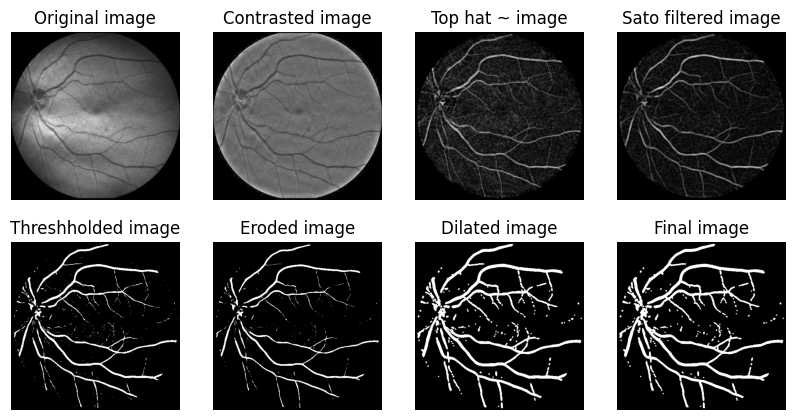

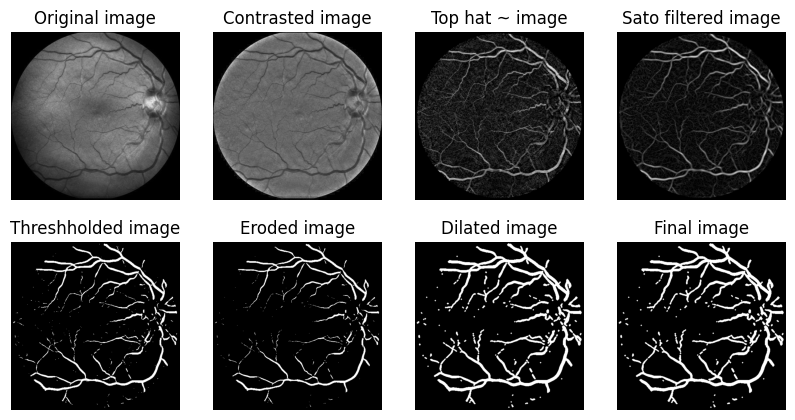

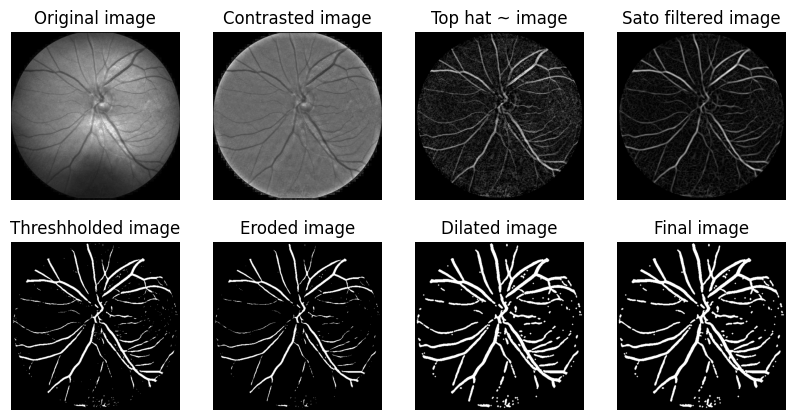

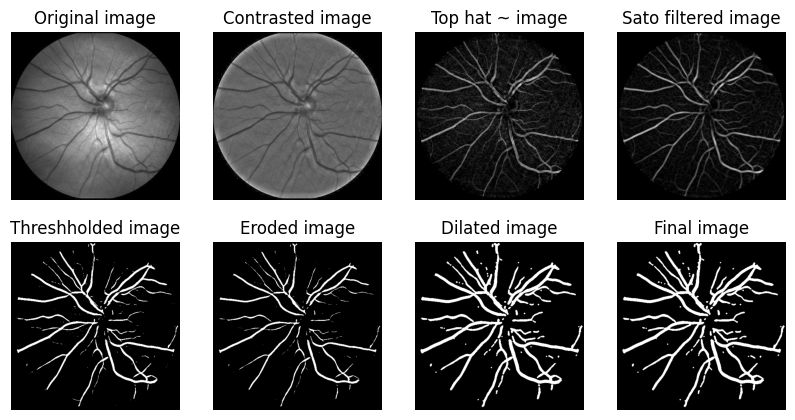

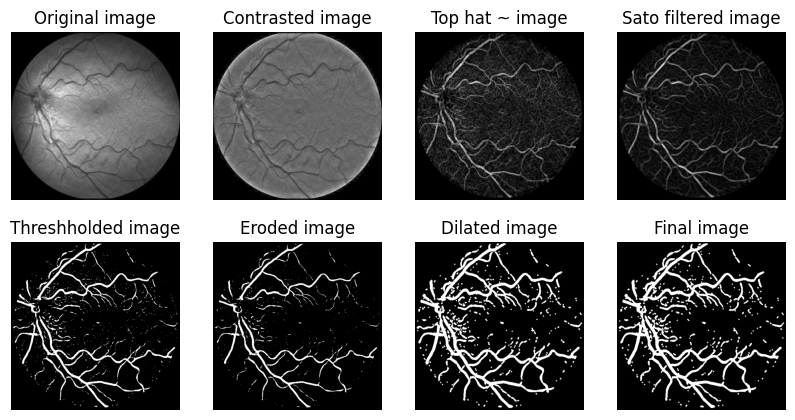

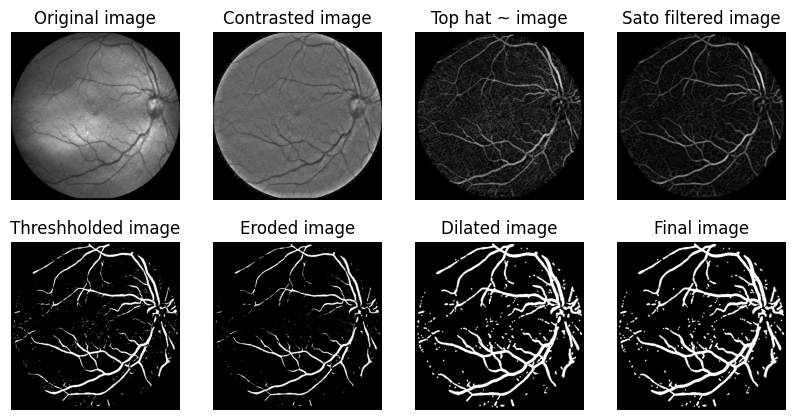

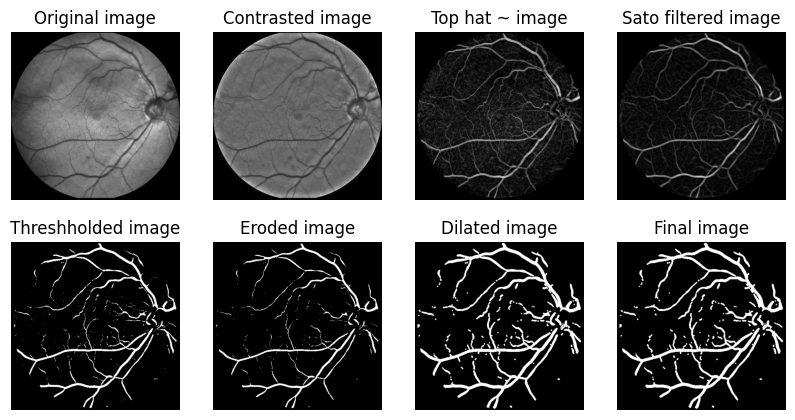

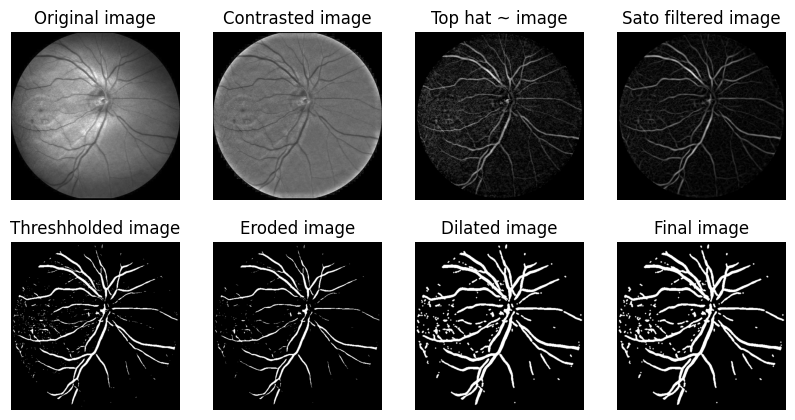

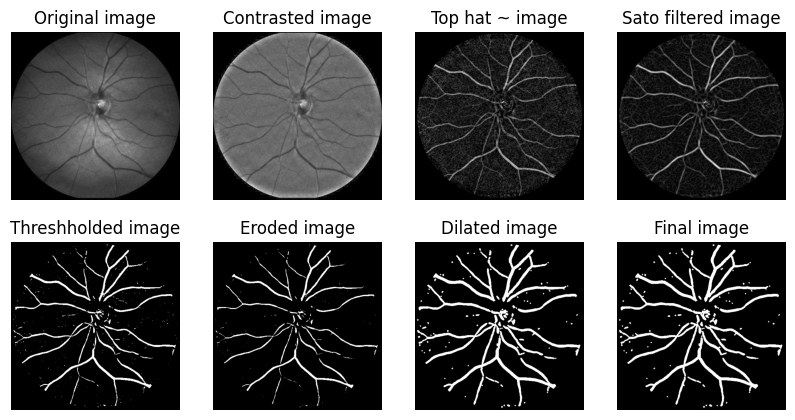

In [295]:
images = ["01_OSC", "02_OSC", "03_OSN", "08_OSN", "21_OSC", "26_ODC", "32_ODC", "37_ODN", "48_OSN"]

for image_name in images:
    img =  np.asarray(Image.open('./images_IOSTAR/star' + image_name + '.jpg')).astype(np.uint8)

    nrows, ncols = img.shape
    row, col = np.ogrid[:nrows, :ncols]
    img_mask = (np.ones(img.shape)).astype(np.bool_)
    invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > ((0.975 * nrows / 2)**2))
    img_mask[invalid_pixels] = 0

    nb_lines = 6
    for i in range(ncols):
        for j in range(nb_lines):
            img_mask[j][i] = 0
            img_mask[nrows - j - 1][i] = 0

    img_out = my_segmentation(img, img_mask, if_print=True)
    img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_' + image_name[0:2] + '.png')).astype(np.bool_)

    ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
    print('./images_IOSTAR/star' + image_name + '.jpg: ' + 'Accuracy = ', round(100 * ACCU, 2),'%', ', Recall = ', round(100*RECALL, 2), '%,'," F-score = ", round(100 * 2 * ACCU * RECALL / (ACCU + RECALL), 2), "%.", sep="")

# References

[1] Odstrcilik, J., Kolar, R., Budai, A., Hornegger, J., Jan, J., Gazarek, J., Kubena, T., Cernosek, P., Svoboda, O., & Angelopoulou, E. (2013). Retinal vessel segmentation by improved matched filtering: evaluation on a new high‐resolution fundus image database. In IET Image Processing (Vol. 7, Issue 4, pp. 373–383). Institution of Engineering and Technology (IET). https://doi.org/10.1049/iet-ipr.2012.0455

[2] Lyu, X., Cheng, L., & Zhang, S. (2022). The RETA Benchmark for Retinal Vascular Tree Analysis. In Scientific Data (Vol. 9, Issue 1). Springer Science and Business Media LLC. https://doi.org/10.1038/s41597-022-01507-y
